In [45]:
using CollectiveSpins
using QuantumOptics
using PyPlot
using PyCall
using LinearAlgebra
using DifferentialEquations

In [46]:
""" Compute the spin exchange hamiltonian """
function compute_H_SE(N, bMB, Ω_CSC, σp, σm)
    H = SparseOperator(bMB)
    
    for i=1:N, j=1:N
        if i==j
            continue
        end
        σp_MB_i = embed(bMB, i, σp)
        σm_MB_j = embed(bMB, j, σm)
        
        H += Ω_CSC[i, j] * σp_MB_i*σm_MB_j
    end
    return H
end


""" Return H_ZZ for the spin collection S """
function compute_H_ZZ(Nx, Ny, Nz, bMB, Ω_ZZ_coeff)
    H = SparseOperator(bMB)
    Matidx = reshape([1:N;], Nx, Ny, Nz)
    
    for i=1:N
        idx = findall(x->x==i, Matidx)[1]
        x, y, z = idx[1], idx[2], idx[3]

        # Neighbourg displacment
        neighbors = [
        (1, 0, 0), (-1, 0, 0),
        (0, 1, 0), (0, -1, 0),
        (0, 0, 1), (0, 0, -1)
        ]

        for (dx, dy, dz) in neighbors
            xj, yj, zj = x + dx, y + dy, z + dz
            # Check if neighbours are on the lattice
            if 1 <= xj <= Nx && 1 <= yj <= Ny && 1 <= zj <= Nz
                j = LinearIndices((Nx, Ny, Nz))[xj, yj, zj]
                
                H += (Ω_ZZ_coeff[1] * embed(bMB, i, σp*σm)*embed(bMB, j, σp*σm) + 
                    Ω_ZZ_coeff[2] * (embed(bMB, i, σp*σm)*embed(bMB, j, σm*σp) + embed(bMB, i, σm*σp)*embed(bMB, j, σp*σm)) + 
                    Ω_ZZ_coeff[3] * embed(bMB, i, σm*σp)*embed(bMB, j, σm*σp))
            end
        end
    end
    return H
end

compute_H_ZZ

In [47]:
# Variables
Nx,Ny,Nz = [2, 1, 1]
N = Nx*Ny*Nz
d_xy, d_z = 266., 532.
λl = 1299.
a_dim,b_dim,c_dim = [d_xy,d_xy,d_z]./λl
geo = CollectiveSpins.geometry.box(a_dim,b_dim,c_dim;Nx=Nx,Ny=Ny,Nz=Nz)
e = [0,0,1]   # Quantization axis
system = CollectiveSpins.SpinCollection(geo, e, gammas=1.)

Γ0 = 1.
Ω_ZZ_coeff = [53, 42, 33]./Γ0

# Initial state
theta_init = pi/2
phi_init = 0

theta_array = ones(N)*theta_init
phi_array = zeros(N)*phi_init

# Integration time
Tstep, Tend = 1e-3, 1
T = [0:Tstep:Tend;];

In [48]:
Ω_CS = CollectiveSpins.interaction.OmegaMatrix(system)./Γ0
Γ_CS = CollectiveSpins.interaction.GammaMatrix(system)./Γ0;

In [49]:
# Define Spin basis/operators
b1 = SpinBasis(1//2)
bMB = CompositeBasis([b1 for i=1:N])

# Single atom operators
I1 = identityoperator(b1)
IMB = identityoperator(bMB)
σx = sigmax(b1)
σy = sigmay(b1)
σz = sigmaz(b1)
σm = sigmam(b1)
σp = sigmap(b1)

# Many-body operators
Jx = sum([embed(bMB, i, σx) for i = 1:N])
Jy = sum([embed(bMB, i, σy) for i = 1:N])
Jz = sum([embed(bMB, i, σz) for i = 1:N])

# Hamiltonian
HSF = compute_H_SE(N, bMB, Ω_CS, σp, σm)
HZZ = compute_H_ZZ(Nx, Ny, Nz, bMB, Ω_ZZ_coeff)

# Jump operators
J = [embed(bMB, i, σm) for i = 1:N];

In [50]:
Ψ0 = CollectiveSpins.quantum.blochstate(phi_array, theta_array)
tout, ρt = timeevolution.master(T, Ψ0, HSF+HZZ, J, rates=Γ_CS, dt=Tstep)
tout, ρt_ZZ = timeevolution.master(T, Ψ0, HZZ, J, rates=zeros(N, N), dt=Tstep)
tout, ρt_CS = timeevolution.master(T, Ψ0, HZZ, J, rates=Γ_CS, dt=Tstep);

In [51]:
mean_σx = [real(expect(Jx, ρ))./N for ρ in ρt]
mean_σy = [real(expect(Jy, ρ))./N for ρ in ρt]
mean_σz = -1 .*([real(expect(Jz, ρ))./N for ρ in ρt].+1) ./2 .- 6;

corr_σx = [real(expect(embed(bMB, 1, σx)*embed(bMB, 2, σx), ρ))./N for ρ in ρt]

mean_σx_ZZ = [real(expect(Jx, ρ))./N for ρ in ρt_ZZ]
mean_σy_ZZ = [real(expect(Jy, ρ))./N for ρ in ρt_ZZ]
mean_σz_ZZ = -1 .*([real(expect(Jz, ρ))./N for ρ in ρt_ZZ].+1) ./2 .- 6

mean_σz_CS = -1 .*([real(expect(Jz, ρ))./N for ρ in ρt_CS].+1) ./2 .- 6;

In [52]:
function sigmax_mano(T, Ω_ZZ_coeff)
    return (cos.(2*(Ω_ZZ_coeff[1]-Ω_ZZ_coeff[2]).*T) + cos.(2*(Ω_ZZ_coeff[3]-Ω_ZZ_coeff[2]).*T))./N
end

sigmax_mano (generic function with 1 method)

In [53]:
fsolve(u, p, t) = Γ_CS[1, 2]*((cos(2*(Ω_ZZ_coeff[1]-Ω_ZZ_coeff[2])t) + cos(2*(Ω_ZZ_coeff[3]-Ω_ZZ_coeff[2])*t))/N)^2
prob = ODEProblem(fsolve, 0, (T[1], T[end]))
sol = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8, saveat=Tstep).u;

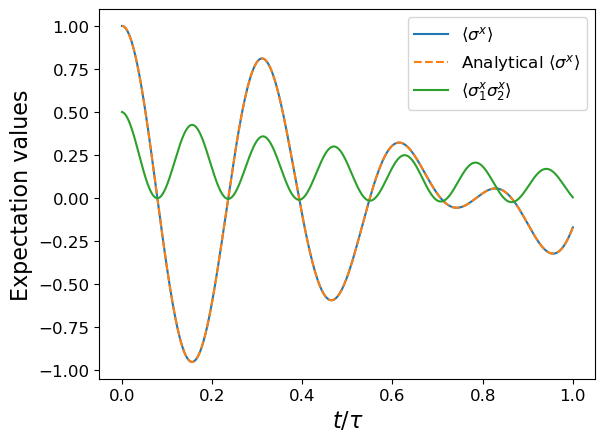

In [55]:
close("all")
PyPlot.rc("font", size = 12)
plot(T, mean_σx_ZZ, label=L"$\langle\sigma^x\rangle$")
plot(T, sigmax_mano(T, Ω_ZZ_coeff), label=L"Analytical $\langle\sigma^x\rangle$", linestyle="--")
plot(T, corr_σx, label=L"$\langle\sigma^x_1\sigma^x_2\rangle$")
#plot(T, sigmax_mano(T, Ω_ZZ_coeff).^2, label=L"$\langle\sigma^x_1\sigma^x_2\rangle$ analytically")
#plot(T, sol*10)
xlabel(L"t/\tau", fontsize=16)
ylabel("Expectation values", fontsize=16)
legend()
savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/HmgtOscillationFrequency.pdf", bbox_inches="tight")
